In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession.builder.appName('YelpRec').getOrCreate()
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])


In [3]:
dataDir = "gs://msca-bdp-student-gcs/group2/yelp-datasample"
business = spark.read.json(dataDir + "/sample_business")
checkin = spark.read.json(dataDir + "/sample_checkin")
review = spark.read.json(dataDir + "/sample_review")
tip = spark.read.json(dataDir + "/sample_tip")
user = spark.read.json(dataDir + "/sample_user")

23/08/12 22:15:47 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
business.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|  400 Pasadena Ave S|                null|qkRM_2X51Yqxk3btl...|Synagogues, Relig...|St. Petersburg|{9:0-17:0, 9:0-17...|      1|     27.76659|    -82.732983|      Temple Beth-El|      33707|           5|  3.5|   FL|
|     625 N Stone Ave|{null, null, null...|rBmpy_Y1UbBx8ggHl...|Automotive, Auto ...|        Tucson|{8:0-17:0, 0:0-0:...|      1|   

In [6]:
business.take(1)

[Row(address='400 Pasadena Ave S', attributes=None, business_id='qkRM_2X51Yqxk3btlwAQIg', categories='Synagogues, Religious Organizations', city='St. Petersburg', hours=Row(Friday='9:0-17:0', Monday='9:0-17:0', Saturday=None, Sunday=None, Thursday='9:0-17:0', Tuesday='9:0-17:0', Wednesday='9:0-17:0'), is_open=1, latitude=27.76659, longitude=-82.732983, name='Temple Beth-El', postal_code='33707', review_count=5, stars=3.5, state='FL')]

In [7]:
business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

## Recommendation system

In [88]:
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
import matplotlib.pyplot as plt
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
%matplotlib inline

In [9]:
df_business = business.select("business_id","name", "stars", 
                                 "review_count", "attributes", 
                                 "categories", "city").withColumnRenamed("stars", "stars_restaurant")

#df_business = df_business.filter((df_business['city'] == 'Toronto') & (df_business.categories.contains('Restaurants'))).drop('city')
df_business = df_business.filter(df_business.categories.contains('Restaurants')).drop('city')

In [10]:
df_review = review.join(df_business, on='business_id', how='inner')

In [15]:
df_review = df_review.select(['business_id', 'user_id', 'stars'])

In [16]:
df_review.show(5)

+--------------------+--------------------+-----+
|         business_id|             user_id|stars|
+--------------------+--------------------+-----+
|-sTrihdzACrsOSu1F...|X-amyxsPEkrxDcWpL...|  5.0|
|Mw4IoBY_CXr8oFhbF...|R0Oq3dyj2VkvcYxkM...|  1.0|
|E7RtIisUoRMcADSeb...|sdIiCY-gq-zEZ4csX...|  4.0|
|5dIS6fNq-t5tdj5X5...|AnE2RCheDAYEpFa4H...|  4.0|
|-zbTnIz1zPNPmKpO0...|B8wYdIyXRJIlhIg3W...|  1.0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [17]:
#df_review.take(1)

In [18]:
df_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- stars: double (nullable = true)



In [19]:
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['business_id', 'user_id']]
pipeline = Pipeline(stages=indexer)
df_review = pipeline.fit(df_review).transform(df_review)
df_review.show(5)

23/08/12 22:53:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1943.3 KiB


+--------------------+--------------------+-----+-----------------+-------------+
|         business_id|             user_id|stars|business_id_index|user_id_index|
+--------------------+--------------------+-----+-----------------+-------------+
|-sTrihdzACrsOSu1F...|X-amyxsPEkrxDcWpL...|  5.0|            293.0|      22973.0|
|Mw4IoBY_CXr8oFhbF...|R0Oq3dyj2VkvcYxkM...|  1.0|            529.0|      19609.0|
|E7RtIisUoRMcADSeb...|sdIiCY-gq-zEZ4csX...|  4.0|             16.0|      35817.0|
|5dIS6fNq-t5tdj5X5...|AnE2RCheDAYEpFa4H...|  4.0|            649.0|      10238.0|
|-zbTnIz1zPNPmKpO0...|B8wYdIyXRJIlhIg3W...|  1.0|            517.0|      10422.0|
+--------------------+--------------------+-----+-----------------+-------------+
only showing top 5 rows



In [42]:
(training, test) = df_review.randomSplit([0.8, 0.2])

In [43]:
# repartition the data to increase efficiency

#training.rdd.getNumPartitions()

In [44]:
#training = training.repartition(6)

In [45]:
#training.show(5)

In [46]:
#test.rdd.getNumPartitions()

In [47]:
#test = test.repartition(6)

In [48]:
#test.show(5)

In [49]:
als=ALS(maxIter=5,
        regParam=0.09,
        rank=10,
        #numUserBlocks: 6, numItemBlocks = 6,
        userCol="user_id_index",
        itemCol="business_id_index",
        ratingCol="stars",
        coldStartStrategy="drop",  #drop any rows in the DataFrame of predictions that contain NaN values
        nonnegative=True)

model=als.fit(training)

23/08/12 23:29:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1996.1 KiB
23/08/12 23:29:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1999.4 KiB
23/08/12 23:29:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2000.9 KiB
23/08/12 23:29:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2002.1 KiB
23/08/12 23:29:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2001.1 KiB
23/08/12 23:29:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2002.4 KiB
23/08/12 23:29:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2003.1 KiB
23/08/12 23:30:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2006.2 KiB
23/08/12 23:30:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

In [50]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="stars",predictionCol="prediction")

In [51]:
predictions=model.transform(test)
rmse=evaluator.evaluate(predictions)
print("RMSE="+str(rmse))

23/08/12 23:30:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2027.3 KiB
23/08/12 23:30:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2026.0 KiB
23/08/12 23:30:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/08/12 23:30:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB


RMSE=2.4912800093400143


23/08/12 23:30:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB


In [55]:
# Generate top 10 restaurants recommendation for a specific user

userRecs = model.recommendForAllUsers(10).filter(col('user_id_index')==30).select("recommendations").collect()

23/08/12 23:32:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/08/12 23:33:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB


In [84]:
topRestaurants = []
for item in userRecs[0][0]:        
    topRestaurants.append(item.business_id_index)
    
schema = StructType([StructField("business_id_index",IntegerType(),True)])
res = spark.createDataFrame(topRestaurants,IntegerType()).toDF("business_id_index")

In [85]:
res.show()

+-----------------+
|business_id_index|
+-----------------+
|             3035|
|             2772|
|             2984|
|             3623|
|             2220|
|             2683|
|             3012|
|             3952|
|             2407|
|             1746|
+-----------------+



In [67]:
res = res.join(df_review, on = 'business_id_index', how = 'inner').select(['business_id'])
res.show()

+--------------------+
|         business_id|
+--------------------+
|1xF6JoMExE6-7Rowr...|
|1xF6JoMExE6-7Rowr...|
|YKWo9g1-uHJv5-NDW...|
|YKWo9g1-uHJv5-NDW...|
|YKWo9g1-uHJv5-NDW...|
|xdaZAn6Uu6vEbub08...|
|xdaZAn6Uu6vEbub08...|
|xdaZAn6Uu6vEbub08...|
|xZfQSLDjtqqmF1Jfl...|
|xZfQSLDjtqqmF1Jfl...|
|xPSetcLWfl_3JoENf...|
|xPSetcLWfl_3JoENf...|
|xPSetcLWfl_3JoENf...|
|xPSetcLWfl_3JoENf...|
|xPSetcLWfl_3JoENf...|
|IUK6iwuTE7746Fryl...|
|IUK6iwuTE7746Fryl...|
|IUK6iwuTE7746Fryl...|
|-ol8_w6-ArmKBw-GM...|
|-ol8_w6-ArmKBw-GM...|
+--------------------+
only showing top 20 rows



In [68]:
res.printSchema()

root
 |-- business_id: string (nullable = true)



In [69]:
res = res.join(df_business, on = 'business_id', how = 'inner').select(['business_id','name','categories'])
res.show()

+--------------------+--------------------+--------------------+
|         business_id|                name|          categories|
+--------------------+--------------------+--------------------+
|1xF6JoMExE6-7Rowr...|V Cafe Ok Vietnam...|Food, Restaurants...|
|1xF6JoMExE6-7Rowr...|V Cafe Ok Vietnam...|Food, Restaurants...|
|YKWo9g1-uHJv5-NDW...|       Pizza Village|Pizza, Restaurant...|
|YKWo9g1-uHJv5-NDW...|       Pizza Village|Pizza, Restaurant...|
|YKWo9g1-uHJv5-NDW...|       Pizza Village|Pizza, Restaurant...|
|xdaZAn6Uu6vEbub08...|    Shep's Food Mart|Grocery, Delis, F...|
|xdaZAn6Uu6vEbub08...|    Shep's Food Mart|Grocery, Delis, F...|
|xdaZAn6Uu6vEbub08...|    Shep's Food Mart|Grocery, Delis, F...|
|xZfQSLDjtqqmF1Jfl...|Original J’s Tex-...|Mexican, Barbeque...|
|xZfQSLDjtqqmF1Jfl...|Original J’s Tex-...|Mexican, Barbeque...|
|xPSetcLWfl_3JoENf...|   Sauce On The Side|Italian, Barbeque...|
|xPSetcLWfl_3JoENf...|   Sauce On The Side|Italian, Barbeque...|
|xPSetcLWfl_3JoENf...|   

In [72]:
res.dropDuplicates(subset=['business_id']).show(truncate=False)

+----------------------+---------------------------------+-----------------------------------------------------------------------------------------+
|business_id           |name                             |categories                                                                               |
+----------------------+---------------------------------+-----------------------------------------------------------------------------------------+
|N1CtJT2fu8U84Ua-sTyVwQ|Bel Mar Tavern                   |Sports Bars, American (New), Bars, Nightlife, Restaurants, Beer Bar                      |
|xZfQSLDjtqqmF1JfluXZng|Original J’s Tex-Mex Barbecue    |Mexican, Barbeque, Tacos, Tex-Mex, Restaurants                                           |
|IUK6iwuTE7746Fryl4BJew|Jillybean's Ice Cream & Treats   |Desserts, Ice Cream & Frozen Yogurt, Sandwiches, Cheesesteaks, Burgers, Restaurants, Food|
|ZVlSFGoacedJIPGzlZvy6A|Outlaw Saloon                    |Restaurants, Nightlife, American (Traditional), 

In [74]:
res_categories = res.select('categories').collect()
res_categories = [res_categories[i][0] for i in range(len(res_categories))]

In [75]:
text = " ".join(i for i in res_categories)

In [81]:
#text

'Food, , Specialty Food, Ethnic Food, Vietnamese Food, , Specialty Food, Ethnic Food, Vietnamese Pizza, , Italian, Chicken Wings Pizza, , Italian, Chicken Wings Pizza, , Italian, Chicken Wings Grocery, Delis, Food, Beer, Wine & Spirits,  Grocery, Delis, Food, Beer, Wine & Spirits,  Grocery, Delis, Food, Beer, Wine & Spirits,  Mexican, Barbeque, Tacos, Tex-Mex,  Mexican, Barbeque, Tacos, Tex-Mex,  Italian, Barbeque, Beer Bar, , Salad, Nightlife, Bars Italian, Barbeque, Beer Bar, , Salad, Nightlife, Bars Italian, Barbeque, Beer Bar, , Salad, Nightlife, Bars Italian, Barbeque, Beer Bar, , Salad, Nightlife, Bars Italian, Barbeque, Beer Bar, , Salad, Nightlife, Bars Desserts, Ice Cream & Frozen Yogurt, Sandwiches, Cheesesteaks, Burgers, , Food Desserts, Ice Cream & Frozen Yogurt, Sandwiches, Cheesesteaks, Burgers, , Food Desserts, Ice Cream & Frozen Yogurt, Sandwiches, Cheesesteaks, Burgers, , Food , American (New), Sea , American (New), Sea Sports Bars, American (New), Bars, Nightlife, , B

In [78]:
#pip install wordcloud

Exception ignored in: <function JavaWrapper.__del__ at 0x7f66763271f0>
Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'ALS' object has no attribute '_java_obj'


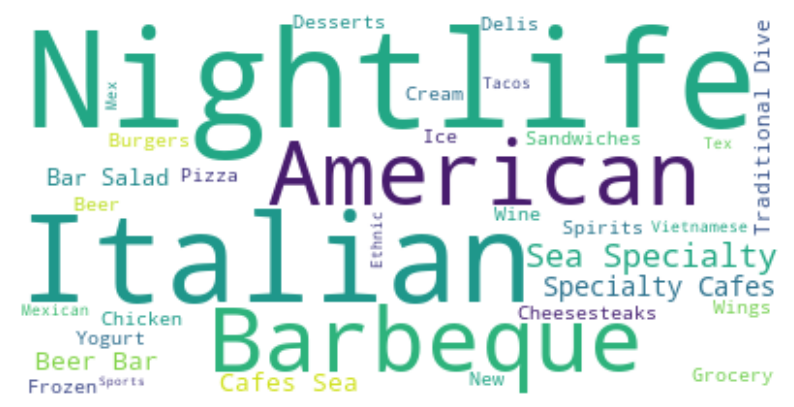

In [82]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# eliminate useless words
text = text.replace('Restaurants', "")
text = text.replace('Bars', "")
text = text.replace('Food', "")

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### hyperparameter tuning

In [86]:
ALSExplicit = ALS( implicitPrefs=False, userCol="user_id_index", itemCol="business_id_index", ratingCol="stars",
          coldStartStrategy="drop")
defaultModel = ALSExplicit.fit(training)


23/08/13 00:21:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1996.1 KiB
23/08/13 00:21:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1999.3 KiB
23/08/13 00:21:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2000.8 KiB
23/08/13 00:21:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2002.1 KiB
23/08/13 00:21:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2001.1 KiB
23/08/13 00:21:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2002.4 KiB
23/08/13 00:21:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2003.1 KiB
23/08/13 00:21:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2006.1 KiB
23/08/13 00:21:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

In [91]:
paramMapExplicit = ParamGridBuilder() \
                    .addGrid(ALSExplicit.rank, [10, 15, 20, 25]) \
                    .addGrid(ALSExplicit.maxIter, [5,10]) \
                    .addGrid(ALSExplicit.regParam, [0.01,0.05, 0.08, 0.001]) \
                    .build()

evaluatorR = RegressionEvaluator(metricName="rmse", labelCol="stars")

In [92]:
paramMapExplicit

[{Param(parent='ALS_a0eeb7340395', name='rank', doc='rank of the factorization'): 10,
  Param(parent='ALS_a0eeb7340395', name='maxIter', doc='max number of iterations (>= 0).'): 5,
  Param(parent='ALS_a0eeb7340395', name='regParam', doc='regularization parameter (>= 0).'): 0.01},
 {Param(parent='ALS_a0eeb7340395', name='rank', doc='rank of the factorization'): 10,
  Param(parent='ALS_a0eeb7340395', name='maxIter', doc='max number of iterations (>= 0).'): 5,
  Param(parent='ALS_a0eeb7340395', name='regParam', doc='regularization parameter (>= 0).'): 0.05},
 {Param(parent='ALS_a0eeb7340395', name='rank', doc='rank of the factorization'): 10,
  Param(parent='ALS_a0eeb7340395', name='maxIter', doc='max number of iterations (>= 0).'): 5,
  Param(parent='ALS_a0eeb7340395', name='regParam', doc='regularization parameter (>= 0).'): 0.08},
 {Param(parent='ALS_a0eeb7340395', name='rank', doc='rank of the factorization'): 10,
  Param(parent='ALS_a0eeb7340395', name='maxIter', doc='max number of i

In [94]:
# Run cross-validation, and choose the best set of parameters.
CVALSExplicit = CrossValidator(estimator=ALSExplicit,
                            estimatorParamMaps=paramMapExplicit,
                            evaluator=evaluatorR,
                           numFolds=5)


CVModelEXplicit = CVALSExplicit.fit(training)

23/08/13 00:28:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2005.9 KiB
23/08/13 00:28:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2009.2 KiB
23/08/13 00:28:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2010.7 KiB
23/08/13 00:28:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2012.0 KiB
23/08/13 00:28:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2010.9 KiB
23/08/13 00:28:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2012.2 KiB
23/08/13 00:28:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2013.0 KiB
23/08/13 00:28:08 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2016.0 KiB
23/08/13 00:28:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

In [95]:
best_model = CVModelEXplicit.bestModel

In [104]:
best_params = best_model.extractParamMap()
for param, value in best_params.items():
    print(f"{param.name}: {value}")

blockSize: 4096
predictionCol: prediction
coldStartStrategy: drop
itemCol: business_id_index
userCol: user_id_index


In [106]:
#best_model.explainParams()

In [109]:
best_model.explainParams()

"blockSize: block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. (default: 4096)\ncoldStartStrategy: strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: 'nan', 'drop'. (default: nan, current: drop)\nitemCol: column name for item ids. Ids must be within the integer value range. (default: item, current: business_id_index)\npredictionCol: prediction column name. (default: prediction)\nuserCol: column name for user ids. Ids must be within the integer value range. (default: user, current: user_id_index)"

In [111]:
best_model.rank

25

In [120]:
#best_model.getMaxIter()

In [121]:
#best_model.getRegParam()

In [122]:
best_predictions = best_model.transform(test)
best_rmse = evaluator.evaluate(best_predictions)
print("Best RMSE="+str(best_rmse))

23/08/13 01:02:16 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2041.0 KiB
23/08/13 01:02:16 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2039.6 KiB
23/08/13 01:02:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1963.5 KiB
23/08/13 01:02:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/08/13 01:02:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB


Best RMSE=3.915621576682807
